In [1]:
%matplotlib inline

from numpy import sqrt, exp, cos
from clawpack import riemann
from clawpack import pyclaw

def acoustics(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    Basic 1d acoustics riemann solver, with interleaved arrays

    *problem_data* is expected to contain -
     - *zz* - (float) Impedance
     - *cc* - (float) Speed of sound

    See :ref:`pyclaw_rp` for more details.

    :Version: 1.0 (2009-02-03)
    """
    import numpy as np
    num_eqn = 2
    num_waves = 2

    # Convenience
    num_rp = np.size(q_l,1)

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    a1 = (-delta[0,:] + problem_data['zz']*delta[1,:]) / (2.0 * problem_data['zz'])
    a2 = (delta[0,:] + problem_data['zz']*delta[1,:]) / (2.0 * problem_data['zz'])

    # Compute the waves
    # 1-Wave
    wave[0,0,:] = -a1 * problem_data['zz']
    wave[1,0,:] = a1
    s[0,:] = -problem_data['cc']

    # 2-Wave
    wave[0,1,:] = a2 * problem_data['zz']
    wave[1,1,:] = a2
    s[1,:] = problem_data['cc']

    # Compute the left going and right going fluctuations
    for m in range(num_eqn):
        amdq[m,:] = s[0,:] * wave[m,0,:]
        apdq[m,:] = s[1,:] * wave[m,1,:]

    return wave, s, amdq, apdq

def setup(outdir='./_output',  output_style=1):

    #riemann_solver = riemann.acoustics_1D_py.acoustics_1D
    riemann_solver = acoustics
    solver = pyclaw.ClawSolver1D(riemann_solver)
    solver.limiters = pyclaw.limiters.tvd.MC
    solver.kernel_language = 'Python'
    solver.num_waves = 2
    solver.num_eqn = 2
    
    x = pyclaw.Dimension(0.0, 1.0, 100, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain, num_eqn)

    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic

    rho = 1.0   # Material density
    bulk = 1.0  # Material bulk modulus

    state.problem_data['rho'] = rho
    state.problem_data['bulk'] = bulk
    state.problem_data['zz'] = sqrt(rho*bulk)   # Impedance
    state.problem_data['cc'] = sqrt(bulk/rho)   # Sound speed

    xc = domain.grid.x.centers
    beta = 100
    gamma = 0
    x0 = 0.75
    state.q[0, :] = exp(-beta * (xc-x0)**2) * cos(gamma * (xc - x0))
    state.q[1, :] = 0.0

    solver.dt_initial = domain.grid.delta[0] / state.problem_data['cc'] * 0.1

    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.output_style = output_style
    output_style = 1
    claw.tfinal = 1.0
    claw.num_output_times = 10
    claw.keep_copy = True
    #claw.setplot = setplot

    return claw


def setplot(plotdata):
    """
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of visclaw.data.ClawPlotData.
    Output: a modified version of plotdata.
    """
    plotdata.clearfigures()  # clear any old figures,axes,items data

    # Figure for pressure
    plotfigure = plotdata.new_plotfigure(name='Pressure', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.axescmd = 'subplot(211)'
    plotaxes.ylimits = [-0.2, 1.0]
    plotaxes.title = 'Pressure'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth': 2, 'markersize': 5}

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.axescmd = 'subplot(212)'
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = [-0.5, 1.1]
    plotaxes.title = 'Velocity'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 1
    plotitem.plotstyle = '-'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth': 3, 'markersize': 5}

    return plotdata

In [2]:
claw = setup()
claw.run()

from clawpack.visclaw import data
from clawpack.visclaw import frametools
plotdata = data.ClawPlotData()
plotdata.setplot = setplot
claw.plotdata = frametools.call_setplot(setplot,plotdata)

frame = claw.load_frame(10)
f=claw.plot_frame(frame)

2024-04-01 14:49:58,943 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 14:49:58,951 INFO CLAW: Solution 1 computed for time t=0.100000
2024-04-01 14:49:58,962 INFO CLAW: Solution 2 computed for time t=0.200000


2024-04-01 14:49:58,969 INFO CLAW: Solution 3 computed for time t=0.300000
2024-04-01 14:49:58,978 INFO CLAW: Solution 4 computed for time t=0.400000
2024-04-01 14:49:58,987 INFO CLAW: Solution 5 computed for time t=0.500000
2024-04-01 14:49:58,995 INFO CLAW: Solution 6 computed for time t=0.600000
2024-04-01 14:49:59,004 INFO CLAW: Solution 7 computed for time t=0.700000
2024-04-01 14:49:59,013 INFO CLAW: Solution 8 computed for time t=0.800000
2024-04-01 14:49:59,021 INFO CLAW: Solution 9 computed for time t=0.900000
2024-04-01 14:49:59,031 INFO CLAW: Solution 10 computed for time t=1.000000
Executed setplot successfully


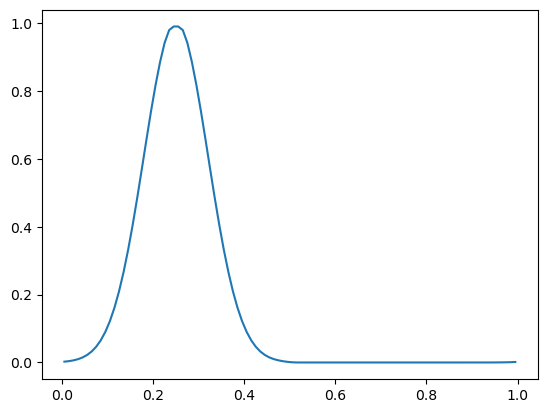

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

frame = claw.frames[5]
w = frame.q[0,:]
x = frame.state.grid.c_centers
x = x[0]

fig=plt.plot(x, w)
plt.savefig("frame5.pdf")

In [4]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig = plt.figure(figsize=(5,3))
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    plt.plot(x, w)
    figs.append(fig)
    plt.close(fig)
    #plt.plot(x, w)

In [5]:
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)

interactive(children=(IntSlider(value=0, description='frameno', max=10), Output()), _dom_classes=('widget-inte…